In [1]:
import os

datapath = os.getcwd()+'\\data'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
TrainData = pd.read_csv(datapath + '\\train.csv')
ValData = pd.read_csv(datapath + '\\val.csv')
TestData = pd.read_csv(datapath + '\\test.csv')

In [4]:
import math

root = len(TrainData.drop(columns=['ID']).columns)**0.5
nrows = math.floor(root)
ncols = math.ceil(root)

arr = np.ones((nrows, ncols))

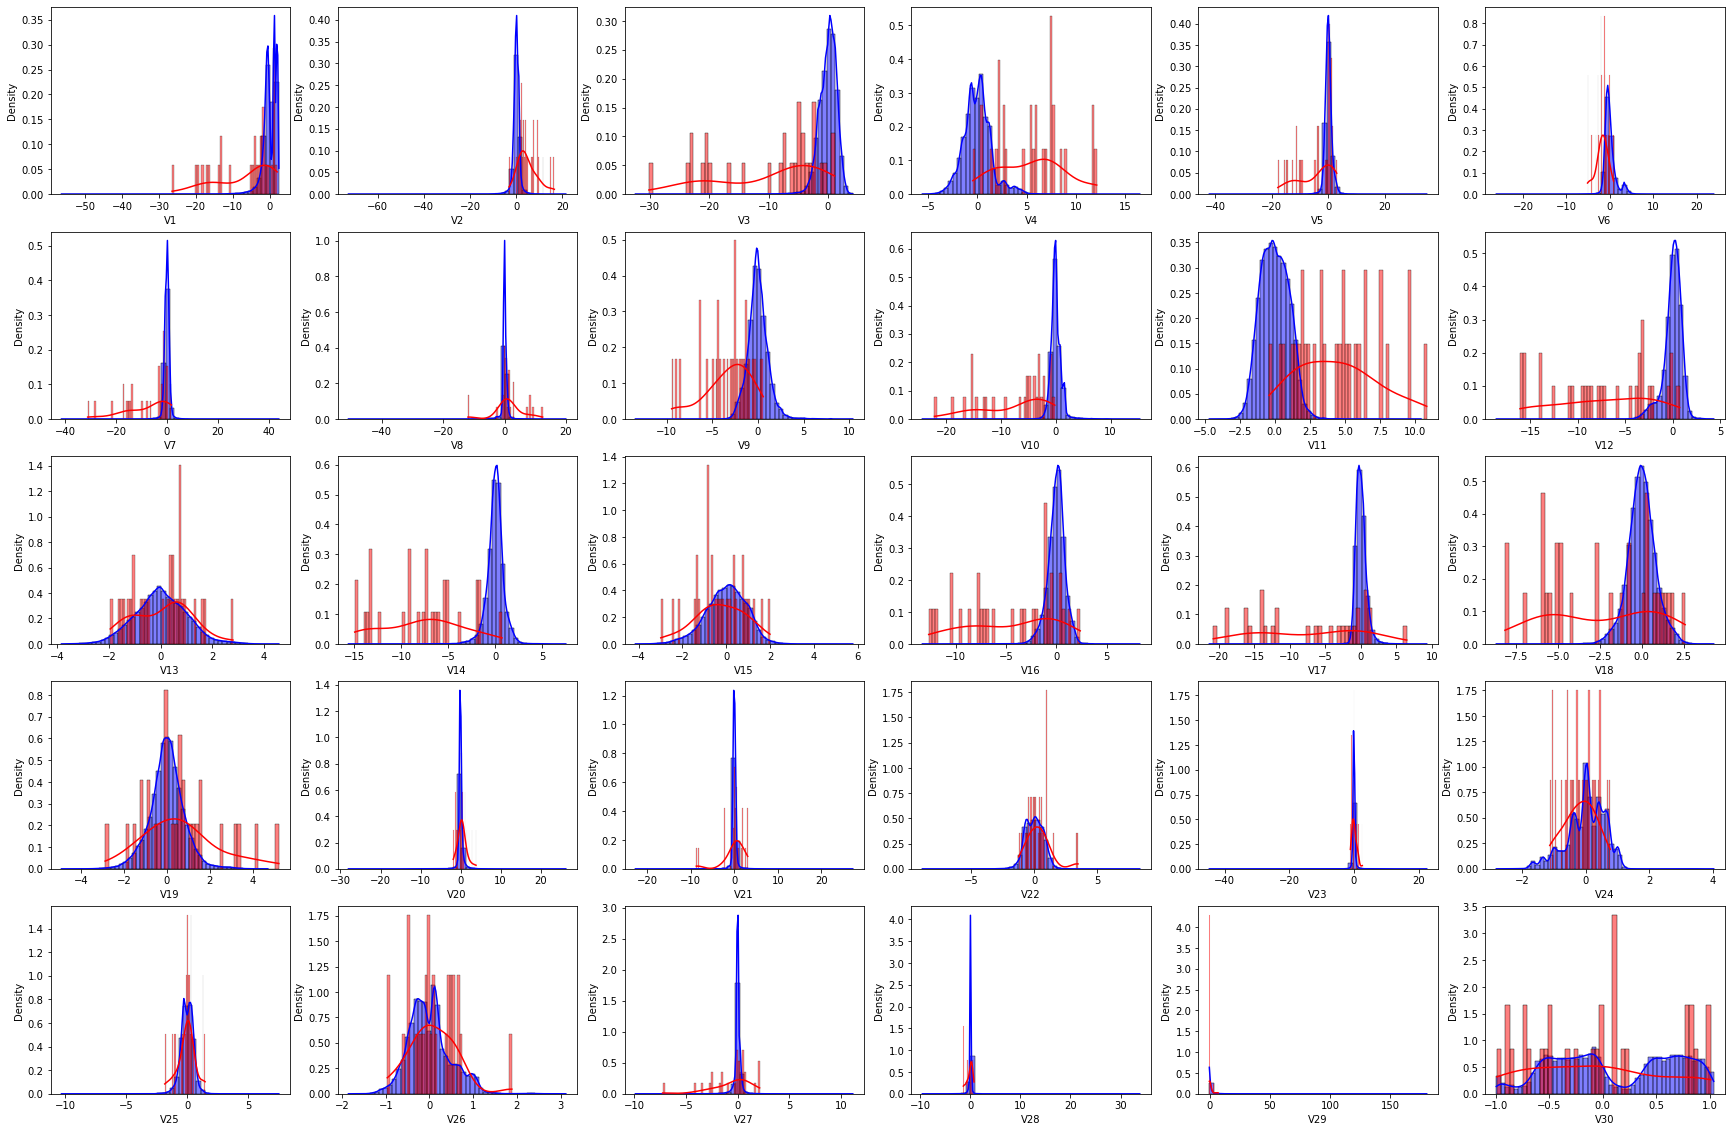

In [5]:
i = []
j = []

for (row,col),x in np.ndenumerate(arr) :
    i = i + [row]
    j = j + [col]

#확률밀도비교
#sharex (True일 경우 X축 공유)
import seaborn as sns

f, axes = plt.subplots(nrows,ncols, figsize=(30,20))

for col, i, j in zip(TrainData.drop(columns=['ID']).columns,i,j) :
    sns.histplot(TrainData[col],ax = axes[i,j], stat = 'density', bins= 50, color = 'blue',kde=True, kde_kws = {'bw_adjust': 1})
    sns.histplot(ValData[ValData['Class']==1][col],ax = axes[i,j], stat = 'density', bins= 50, color = 'red',kde=True, kde_kws = {'bw_adjust': 1})
                 
plt.show()

사기탐지됨 플롯의 확률 밀도를 가져와보자

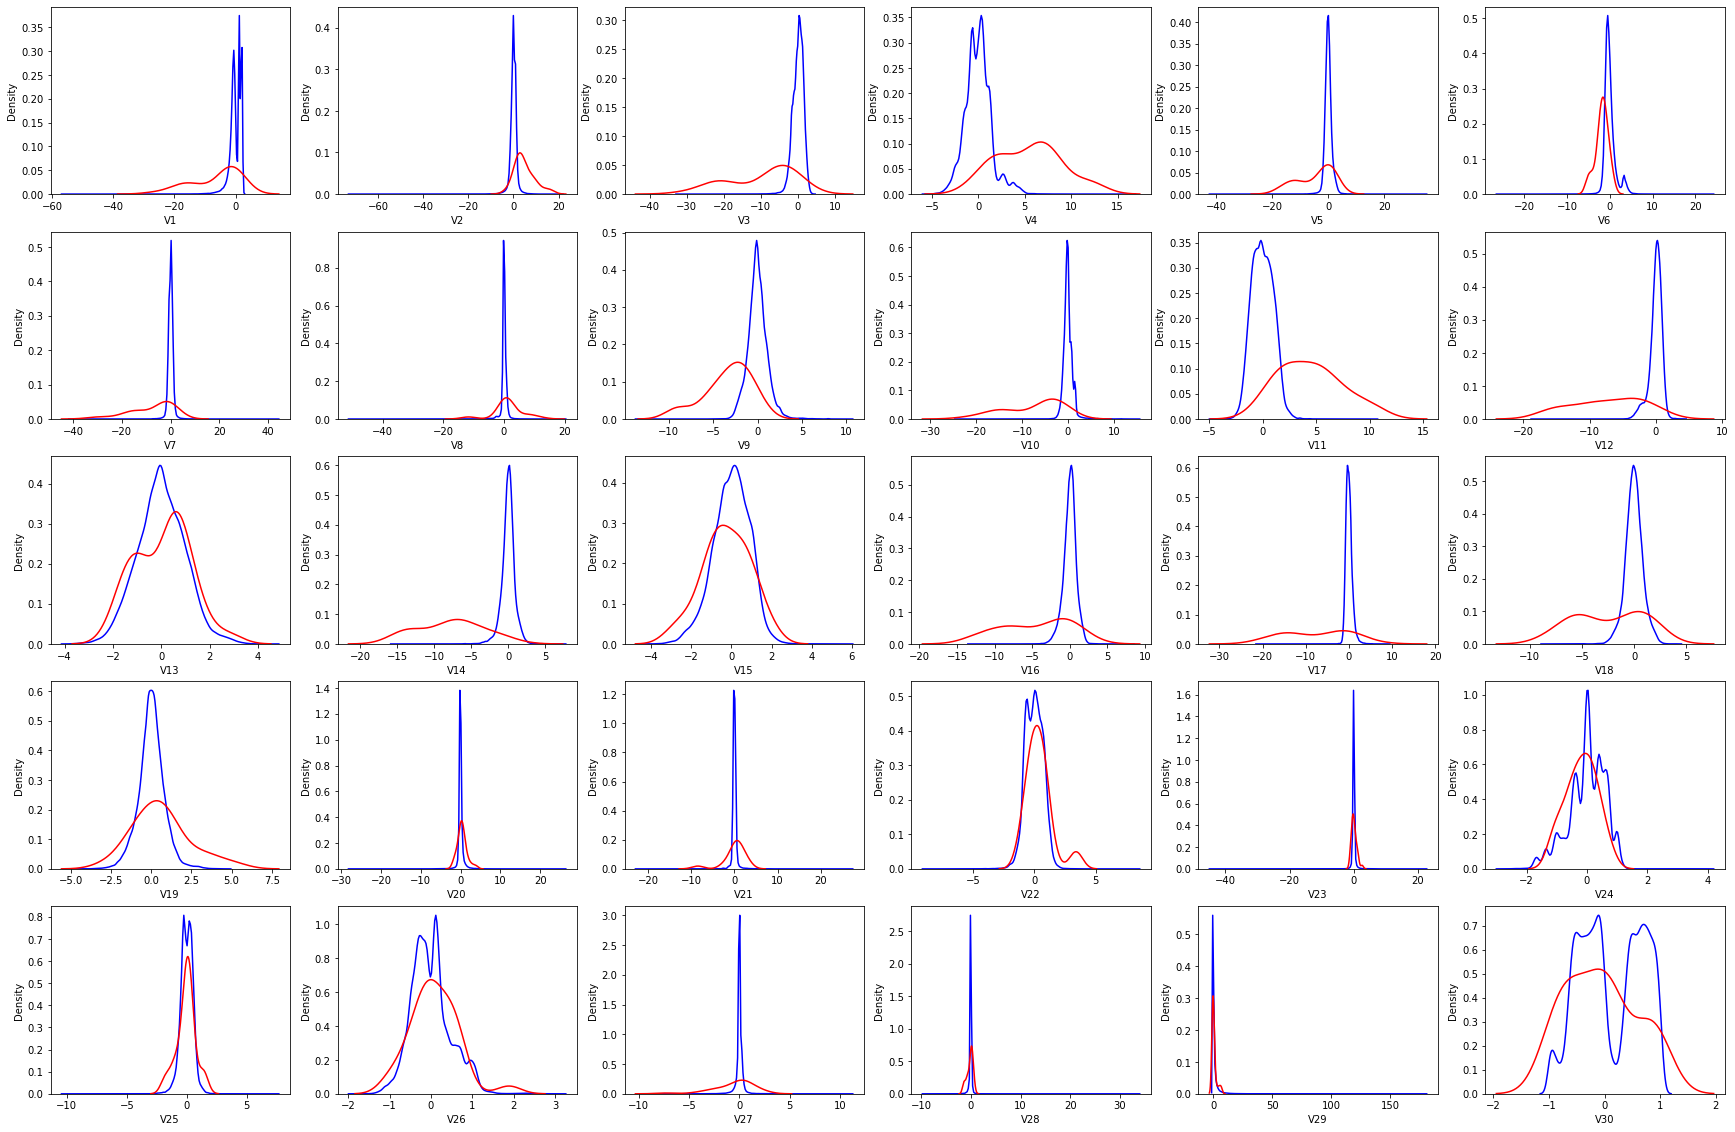

In [6]:
i = []
j = []

for (row,col),x in np.ndenumerate(arr) :
    i = i + [row]
    j = j + [col]

#확률밀도비교
#sharex (True일 경우 X축 공유)
import seaborn as sns

f, axes = plt.subplots(nrows,ncols, figsize=(30,20))

for col, i, j in zip(TrainData.drop(columns=['ID']).columns,i,j) :
    sns.kdeplot(TrainData[col],ax = axes[i,j], color = 'blue')
    sns.kdeplot(ValData[ValData['Class']==1][col],ax = axes[i,j], color = 'red')
                 
plt.show()

In [29]:
#scipy.stats.gaussian_kde 커널을 찾는자

# https://stackoverflow.com/questions/68396403/kernel-density-estimation-using-scipys-gaussian-kde-and-sklearns-kerneldensity
#from scipy.stats import gaussian_kde

# eval_points = np.linspace(np.min(x), np.max(x))
# kde_sp = gaussian_kde(x, bw_method=0.25)
# y_sp = kde_sp.pdf(eval_points)

In [7]:
from scipy.stats import gaussian_kde

In [177]:
v1_data = ValData[ValData['Class']==1]['V3']

opt_bw = 1.059*v1_data.std()*(len(v1_data)**(-0.2))

In [178]:
kde_sp = gaussian_kde(v1_data,bw_method=0.16) #'silverman'
print(kde_sp.factor)
#최적 bw = 1.06*std*(n)**(-0.2) #siverman은 아님

eval_points = np.linspace(np.min(v1_data), np.max(v1_data))

print([kde_sp.integrate_box_1d(-np.Inf,x) for x in eval_points][-1]) #cdf 마지막 값

0.16
0.9586228821400884


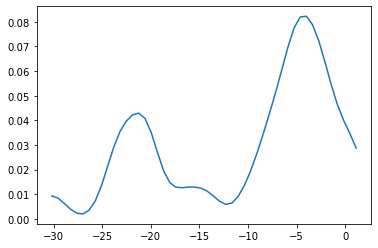

In [179]:
plt.plot(eval_points, kde_sp.pdf(eval_points))

In [180]:
# pdf기반으로 각 값의 확률을 탐색